In [1]:
import gc
import sys

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
from keras.datasets import mnist

from src.activations import Activation
from src.layers import Layer

Using TensorFlow backend.


# Load & pre-process data

In [2]:
num_class = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, np.prod(input_shape)).astype('float32') / 255
x_test = x_test.reshape(-1, np.prod(input_shape)).astype('float32') / 255

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [3]:
X = x_train
Y = y_train
print(f"X: {X.shape}\nY: {Y.shape}")

X: (60000, 784)
Y: (60000, 10)


# Create network

In [4]:
def train(model, X, Y, epochs, batch_size=32, lr=1e-3, validation_data=None):
    hist_values = ["loss", "accuracy"]
    hist = {value: np.zeros(epochs) for value in hist_values}

    size = X.shape[0]
    num_batches = (size + batch_size - 1) // batch_size 
    idx_batches = [(i * batch_size, min(size-1, (i + 1) * batch_size)) for i in range(num_batches)]

    for e in range(epochs):
        for idx_b, idx_e in idx_batches:
            x_batch = X[idx_b:idx_e, ...]
            y_batch = Y[idx_b:idx_e, ...]
            model.backpropagate(x_batch, y_batch, lr=lr)

        y_pred = model.forward(X)
        loss = model.compute_loss(Y, y_pred)
        acc = model.compute_accuracy(Y, y_pred)
        
        hist["loss"][e] = loss
        hist["accuracy"][e] = acc
        
        print(f"[Epoch {e+1}]: loss: {np.round(loss, 3)}\tacc: {np.round(acc, 3)}")

    plt.plot(hist["loss"])
#     plt.figure()
#     plt.plot(hist["accuracy"])

In [5]:
class Sigmoid(Activation):
    def d(self, A):
        return A * (1 - A)
    
    def function(self, z):
        return 1 / (1.0 + np.exp(-z))
    
class Softmax(Activation):
    def d(self, A):
        return A * (1 - A)
    
    def function(self, z):
        s = np.exp(z)
        return s / np.sum(s, axis=-1, keepdims=True)
    

In [355]:
class Dense(Layer):
    def __init__(self, n_o, n_i, activation, sigma=4):
        super().__init__()
        
        self.W = np.random.normal(size=(n_o, n_i)) * sigma / np.sqrt(n_i)
        self.b = np.zeros(shape=(1, n_o))
        
        self.activation = activation
        
    def forward(self, X):
        self.X = X
        h = np.dot(self.X, self.W.T) + self.b
        self.q = np.mean(np.sum(np.square(h), axis=-1)) / self.W.shape[1]
        self.A = self.activation(np.dot(self.X, self.W.T) + self.b)
        return self.A
    
    def d_layer(self):
        if self.X is None:
            raise RuntimeError("This layer needs a forward pass before computing a gradient")
        return self.X

In [356]:
class NeuralNetwork:
    def __init__(self, n_unit):
        self.layers = [ Dense(n_unit[i+1], n_unit[i], activation=Sigmoid()) for i in range(len(n_unit)-1) ]
#         self.layers[-1].activation = Softmax()
        
        self.L = len(self.layers)
        self.A = None
        
    def d_loss(self, Y):
        A = self.A[-1]
        return - (Y / A - (1 - Y) / (1 - A))
        
    def forward(self, X):
        A = [X]
        for idx, layer in enumerate(self.layers):
            A.append(layer(A[idx]))
        self.A = A
        
        return A[-1]
    
    def backpropagate(self, X, Y, lr):
        m = X.shape[-1]
        
        # Probagate
        self.forward(X)
        
        # Compute dW and db
        dWs = []
        dbs = []
        
        for l in reversed(range(1, len(self.layers)+1)):
            if l == self.L:
                dZ = self.d_loss(Y) * self.layers[-1].d_activation()
            else:
                dZ = np.dot(dZ, self.layers[l].W) * self.layers[l-1].d_activation()

            dWs.append( 1/m * np.dot(dZ.T, self.layers[l-1].d_layer()) )
            dbs.append( 1/m * np.sum(dZ, axis=0, keepdims=True) )
        
        dWs = dWs[::-1]
        dbs = dbs[::-1]
        
        # Update weights
        for l, layer in enumerate(self.layers):
            layer.W += - lr * dWs[l]
            layer.b += - lr * dbs[l]
        
    def compute_loss(self, y_true, y_pred):
        return - np.sum( y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred) ) / y_true.shape[0]
    
    def compute_accuracy(self, y_true, y_pred):
        return np.sum( np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1) ) * 100 / y_true.shape[0]
    
    def __iter__(self):
        return iter(self.layers)
    
    def __sizeof__(self):
        return sum([sys.getsizeof(layer) for layer in self])

In [357]:
model = NeuralNetwork(n_unit = [784, 64, 32, 10])

In [358]:
n_points = 100

In [359]:
input_length_range = np.linspace(0, 6, n_points)

In [360]:
q0 = np.zeros((n_points))
q1 = np.zeros((n_points))

for idx, length in enumerate(tqdm(input_length_range)):
    x = np.random.normal(loc=length, scale=1, size=(100, 784))
    model.forward(x)
    q0[idx] = model.layers[0].q
    q1[idx] = model.layers[1].q

100%|██████████| 100/100 [00:00<00:00, 169.36it/s]


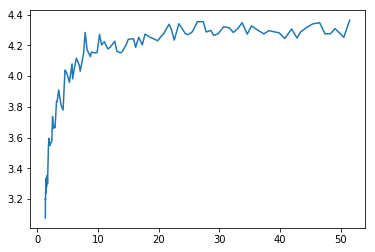

In [361]:
fig, ax = plt.subplots()
ax.plot(q0, q1)

# Train

In [322]:
train(model, X, Y, epochs=3, batch_size=32, lr=3)

[Epoch 1]: loss: 0.655	acc: 90.44


KeyboardInterrupt: 

# Visualization

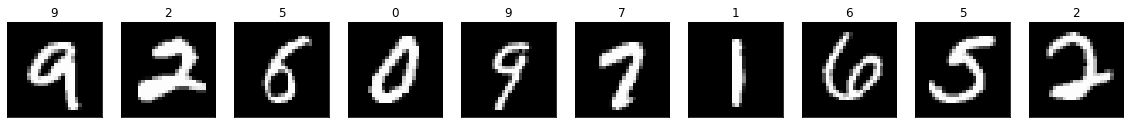

In [10]:
n_images = 10
x_viz = x_test[np.random.randint(0, x_test.shape[0], n_images)]
y_hat = model.forward(x_viz)

plt.figure(figsize=(20, 10))
for i in range(n_images):
    ax = plt.subplot(1, n_images, i + 1)
    plt.imshow(x_viz[i, ...].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'{np.argmax(y_hat[i, ...])}')